In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline



2025-08-26 17:43:17.978674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756230198.267993      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756230198.348822      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/happy-nothappy/train_happy.h5
/kaggle/input/happy-nothappy/test_happy.h5


In [2]:
def load_happy_dataset():
    train_dataset = h5py.File('/kaggle/input/happy-nothappy/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/kaggle/input/happy-nothappy/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


As we can see from above, the images are **64x64** in **RGB**, and this is more than enough for our small from-scratch model.

#### Let's explore a random image

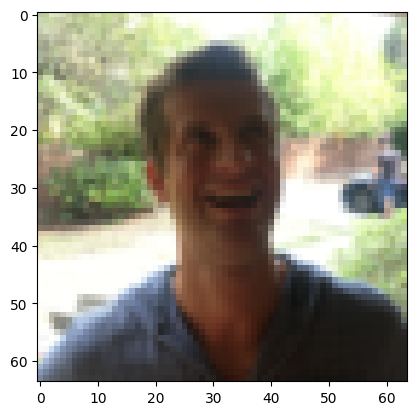

In [4]:
plt.imshow(X_train_orig[3])
plt.show()

In [5]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
     padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    
    return np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)))

### Single Step of Convolution 

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of a different size)


In [6]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    s = a_slice_prev * W # Element wise products
    z = np.sum(s) # Sum over all entries 
    z = z + np.float(b) # Add bias

    return z

The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$

## First the **forward propagation**

In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape  # Retrive dimensions from A_prev'shape

    (f, f, n_C_prev, n_C) = W.shape # Retrieve dimensions from W's shape   ((f -- is the filter window size))

    stride = hparameters['stride'] # Retrieve stride from "hparameters"
    pad = hparameters['pad'] # Retrieve pad from "hparameters"

    # Computing the dimensions of the CONV output volume using the formula given above.
    n_H = int(1 + (n_H_prev - f) / stride)  # height 
    n_W = int(1 + (n_H_prev - f) / stride)  # width


    Z = np.zeros((m, n_H, n_W, n_C))  # Initialize the output volume Z with zeros.

    
    A_prev_pad = zero_pad(A_prev, pad)  #  A_prev_pad by padding A_prev

    

    for i in range(m):                                    # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                        # select ith training example's padded activation
        
        for h in range(n_H):                              # loop over vertical axis of the output volume
            vert_start = h * stride                        # the vertical start of the current "slice"
            vert_end = vert_start + f                     # the vertical  end of the current "slice"

            for w in range(n_W):                      # loop over horizontal axis of the output volume
                horiz_start = w * stride              # the horizontal start of the current "slice"
                horiz_end = horiz_start + f           # the horizontal end of the current "slice"

                for c in range(n_C):                  # loop over channels (= #filters) of the output volume
                        
                    # Use the corners to define the (3D) slice of a_prev_pad
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    weights = W[:,:,:,c]
                        
                    biases = b[0,0,0,c]
                        
                    Z[i, h, w, c] = np.sum(a_slice_prev * weights) + biases
                        
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache
                    

In [8]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """

    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)

    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C_prev))

    for i in range(m):                                 # loop over the training examples
        
        for h in range(n_H):                           # loop on the vertical axis of the output volume
            vert_start = h * stride                    # the vertical start of the current "slice"
            vert_end = vert_start + f                  # the vertical end of the current "slice"
            
            for w in range(n_W):                       # loop on the horizontal axis of the output volume
                horiz_start = w * stride               # the horizontal start of the current "slice"
                horiz_end = horiz_start + f            # the horizontal end of the current "slice"
                
                for c in range(n_C_prev):                   # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c.
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    # Compute the pooling operation on the slice.
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_prev_slice)

     # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    return A, cache

## Now, we will make the **backward propagation**

In [9]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """

        # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C)= W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape

    # Initialize dA_prev, dW, db
    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.zeros_like(b)


    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]

        # Set the ith training example's dA_prev to the unpadded da_prev_pad 
        dA_prev[i, :, :, :] = da_prev_pad[ pad:-pad, pad:-pad, :]

    
    return dA_prev, dW, db
    

In [10]:
def pool_backward(dA, cache, mode="max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters"
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros
    dA_prev = np.zeros_like(A_prev)
    
    for i in range(m):  # Loop over the training examples
        
        # Select training example from A_prev
        a_prev = A_prev[i]
        
        for h in range(n_H):  # Loop on the vertical axis
            for w in range(n_W):  # Loop on the horizontal axis
                for c in range(n_C):  # Loop over the channels (depth)
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        
                        # Create the mask from a_prev_slice
                        mask = (a_prev_slice == np.max(a_prev_slice))
                        
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Get the value da from dA
                        da = dA[i, h, w, c]
                        
                        # Define the shape of the filter as fxf
                        shape = (f, f)
                        
                        # Distribute it to get the correct slice of dA_prev
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.ones(shape) * da / (f * f)


    
    return dA_prev

In [11]:
class ConvLayer:
    def __init__(self, filters, kernel_size, stride=1, padding=0):
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.W = None  # Initialize weights later
        self.b = None  # Initialize biases later
        self.cache_conv = None # Initialize ConvCache later
        
    def forward(self, A_prev):
        # lazy init weights using A_prev channels
        if self.W is None:
            n_C_prev = A_prev.shape[-1]
            f = self.kernel_size
            n_C = self.filters
            # Xavier / He-ish
            scale = np.sqrt(2. / (f * f * n_C_prev))
            self.W = np.random.randn(f, f, n_C_prev, n_C) * scale
            self.b = np.zeros((1,1,1,n_C))
        Z, self.cache_conv = conv_forward(A_prev, self.W, self.b, {'stride': self.stride, 'pad': self.padding})
        return Z

    def backward(self, dZ, learning_rate):
        m = dZ.shape[0]
        dA_prev, dW, db = conv_backward(dZ, self.cache_conv)
        # update (average gradients by m)
        self.W -= learning_rate * (dW / m)
        self.b -= learning_rate * (db / m)
        return dA_prev

In [12]:
class PoolLayer:
    def __init__(self, pool_size, mode="max", stride=None):
        self.pool_size = pool_size
        self.mode = mode
        self.stride = stride if stride else pool_size
        self.cache_pool = None
        
    def forward(self, A_prev):
        ####self.cache = A_prev  # Cache input for backward pass
        Z, self.cache_pool = pool_forward(A_prev, {"f": self.pool_size, "stride": self.stride}, self.mode)
        return Z

    def backward(self, dA, learning_rate= None):
        dA_prev = pool_backward(dA, self.cache_pool, self.mode)
        return dA_prev

In [13]:
class FlattenLayer:
    def __init__(self):
        self.orig_shape = None

    def forward(self, A_prev):
        self.orig_shape = A_prev.shape
        m = A_prev.shape[0]
        return A_prev.reshape(m, -1)

    def backward(self, dA, learning_rate=None):
        return dA.reshape(self.orig_shape)

In [14]:
class FullyConnectedLayer:
    def __init__(self, units):
        self.units = units
        self.W = None  # Initialize weights later
        self.b = None  # Initialize biases later
        self.cache = None
        
    def forward(self, A_prev):
         # A_prev shape (m, d)
        if self.W is None:
            d = A_prev.shape[1]
            # Xavier init
            self.W = np.random.randn(d, self.units) * np.sqrt(2. / d)
            self.b = np.zeros((1, self.units))
        self.cache = A_prev
        Z = A_prev.dot(self.W) + self.b
        return Z

    def backward(self, dZ, learning_rate):
        m = dZ.shape[0]
        A_prev = self.cache
        
        dW = A_prev.T.dot(dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = dZ.dot(self.W.T)
        
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dA_prev

In [15]:
class SequentialModel:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, dA, learning_rate):
        grad = dA
        for layer in reversed(self.layers):
            # pool and flatten accept learning_rate but don't need it
            if isinstance(layer, ConvLayer) or isinstance(layer, FullyConnectedLayer):
                grad = layer.backward(grad, learning_rate)
            else:
                grad = layer.backward(grad, learning_rate)

In [16]:
def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

def softmax(Z):
    shift = Z - np.max(Z, axis=1, keepdims=True)
    exps = np.exp(shift)
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(Z, Y):
    # Z: logits shape (m, C); Y: (m,1) integer labels 0..C-1
    m = Z.shape[0]
    P = softmax(Z)
    C = Z.shape[1]
    Y_onehot = np.eye(C)[Y.reshape(-1)]
    loss = -np.mean(np.sum(Y_onehot * np.log(P + 1e-15), axis=1))
    return loss

def cross_entropy_grad(Z, Y):
    m = Z.shape[0]
    P = softmax(Z)
    C = Z.shape[1]
    Y_onehot = np.eye(C)[Y.reshape(-1)]
    dZ = (P - Y_onehot) / m
    return dZ

In [17]:
def train(model, X_train, Y_train, epochs, learning_rate):
    for epoch in range(epochs):
        # Forward pass
        A = X_train
        caches_for_relu = []   # we'll use a simple pattern: conv->relu->pool->...; so we re-run forward with activations here
        # To keep it simple: do forward with activations inline:
        A = model.forward(X_train)  # final logits (note: our model architecture includes ReLU layers explicitly)
        loss = cross_entropy_loss(A, Y_train)

        # Backward pass
        dA = cross_entropy_grad(A, Y_train)
        model.backward(dA, learning_rate)

        print(f"Epoch {epoch+1}/{epochs}  Loss: {loss:.5f}")

In [18]:
class ReLULayer:
    def __init__(self):
        self.Z = None
    def forward(self, X):
        self.Z = X
        return np.maximum(0, X)
    def backward(self, dA, learning_rate=None):
        dZ = dA.copy()
        dZ[self.Z <= 0] = 0
        return dZ

# Build model
model = SequentialModel()

# conv->relu->pool
model.add(ConvLayer(filters=8, kernel_size=3, stride=1, padding=1))
model.add(ReLULayer())
model.add(PoolLayer(pool_size=2, mode="max", stride=2))

# conv->relu->pool
model.add(ConvLayer(filters=16, kernel_size=3, stride=1, padding=1))
model.add(ReLULayer())
model.add(PoolLayer(pool_size=2, mode="max", stride=2))

# FlattenLayer
model.add(FlattenLayer())

# Fullyconnected->relu
model.add(FullyConnectedLayer(units=64))
model.add(ReLULayer())

# classification layer (output layer)
model.add(FullyConnectedLayer(units=2))  # logits for 2 classes


In [ ]:
## Only 3 epochs because the model with this Python implementation does not support GPU acceleration, but it's working !! 
train(model, X_train, Y_train, epochs=3, learning_rate=0.01)


Epoch 1/3  Loss: 0.73540
Epoch 2/3  Loss: 0.73523
